# Examination of the impacts of taking a multi model ensemble mean for MIROC; Feb 2024

In [1]:
%reset -f

In [2]:
%load_ext autoreload

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
# analysis functions
import xarray as xr
import numpy as np
import pandas as pd

# plotting functions
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# systems functions
import os
from collections import defaultdict

# my own classes and functions
from GradTrendClasses import ModelInput, Trend, TrendPlotting, CalculateMMEGradient, CalculateObsGradient
from GradientProjectFunctions import CropTrendsDf, RemoveClimatology

## Calculating the MM mean of the gradient (i.e., averaging the time series from the distinct inputs)

In [5]:
gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients'
gradientMean = CalculateMMEGradient(gradientsDir)

/home/hbyrne/miniconda3/envs/hb_1129/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
libtbb.so.2: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## Now running the trend class on it

In [6]:
trends = Trend(gradientMean).trends
trendsDf = Trend(gradientMean).trendsDf

## Plotting the trends

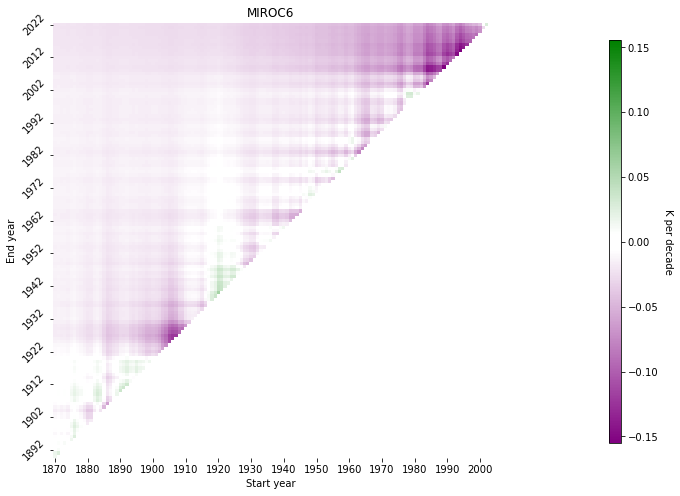

In [7]:
# cropping the trends Df so that plotting doesn't include deadspace
offset = 20 # years
trendsDfCrop = CropTrendsDf(trendsDf, offset)

# calculate the vmin and vmax
vmin = trendsDf.min().min()
vmax = trendsDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
# setting the colorbar
colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig = plt.figure(figsize = (8,8))
axesList = []

ax = fig.add_subplot(111)
ax.set_aspect('equal')
trendPlotter = TrendPlotting(trendsDfCrop, 'MIROC6', vmin, vmax, cmap, norm)
ax = trendPlotter.PlotTrends(ax)  
axesList.append(ax)

cbarAx = fig.add_axes([1.1, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('K per decade', rotation = 270, labelpad = 15)

plt.show()

# Observational dataset input and calculation

In [8]:
obsDir = '/home/hbyrne/Research/QMDA_2023'
fileName = 'HadISST_sst 2.nc'
os.chdir(obsDir)

In [9]:
# running the classes on it
modelInput = ModelInput(fileName)

# have to roll the coordinates for Hadley
modelInput = modelInput.ds.assign_coords(lon = ((360 + (modelInput.ds.lon % 360)) % 360))
modelInput = modelInput.roll(lon = int(len(modelInput['lon']) / 2), roll_coords = True)

# remove climatology
modelInput = RemoveClimatology(modelInput)

# calculate the gradient
gradient = CalculateObsGradient(modelInput, 'HadleyISST')

# calculate the trend
trends = Trend(gradient).trends
trendsDf = Trend(gradient).trendsDf

## Plotting the trends

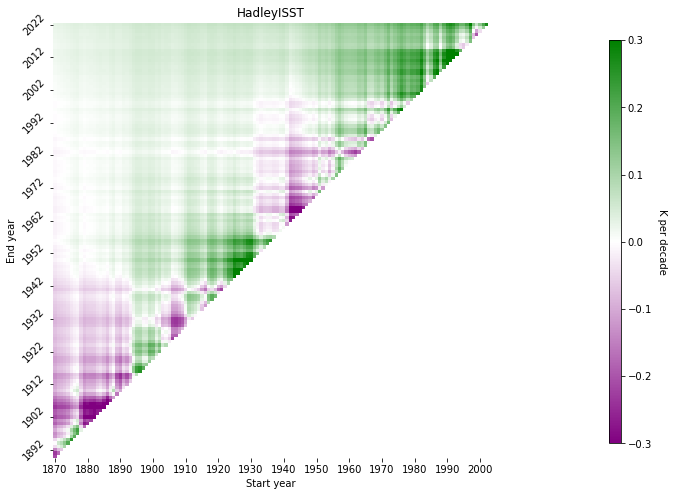

In [10]:
# cropping the trends Df so that plotting doesn't include deadspace
offset = 20 # years
trendsDfCrop = CropTrendsDf(trendsDf, offset)

# calculate the vmin and vmax
vmin = trendsDf.min().min()
vmax = trendsDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
vmin = -0.3
vmax = -vmin
    
# setting the colorbar
colors = [(0,'purple'), (0.50,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig = plt.figure(figsize = (8,8))
axesList = []

ax = fig.add_subplot(111)
ax.set_aspect('equal')
trendPlotter = TrendPlotting(trendsDfCrop, 'HadleyISST', vmin, vmax, cmap, norm)
ax = trendPlotter.PlotTrends(ax)  
axesList.append(ax)

cbarAx = fig.add_axes([1.1, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('K per decade', rotation = 270, labelpad = 15)

plt.show()

# Calculating distributions of trends for each start and end date, plotting obs versus that

In [11]:
trendsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Trends'
os.chdir(trendsDir)

In [12]:
# get a list of all of the files in the directory (getting rid of the python checkpoints one)
trendFiles = os.listdir(trendsDir)
trendFiles = [f for f in trendFiles if '.csv' in f]

# initialise the dictionary
trendsDict = defaultdict(list)

for file in trendFiles:
    trendFile = pd.read_csv(file, index_col = 0)
    trendFile.columns = [int(col) for col in trendFile.columns]
    
    # cropping to the period that we're interested in: 1870 - 1890
    keepCols = [col for col in trendFile.columns if col >= 1870]
    keepRows = [row for row in trendFile.index if row >= 1890]
    trendFile = trendFile.loc[keepRows, keepCols]
    
    # iterate through the start and end years
    for startYear in trendFile.columns.tolist():
        for endYear in trendFile.index.tolist():
            if (endYear > startYear):
                trend = trendFile.loc[endYear, startYear]
                trendsDict[startYear, endYear].append(trend)

trendsDict = dict(trendsDict)

In [13]:
# now create 2 more dictionaries: 5th and 95th percentile
perLower = 2.5
perUpper = 97.5

dictLower = defaultdict(list)
dictUpper = defaultdict(list)

# loop through the keys and save the values
for key in trendsDict:
    dictLower[key] = np.percentile(trendsDict[key], perLower)
    dictUpper[key] = np.percentile(trendsDict[key], perUpper)
    
dictLower = dict(dictLower)
dictUpper = dict(dictUpper)

In [14]:
# now flag True for every instance where the observations lies within the range
dictObsInRange = defaultdict(list)

for key in trends:
    if key in dictLower.keys():
        if not (np.isnan(dictLower[key]) | np.isnan(dictUpper[key])):
            if (trends[key] > dictLower[key]) & (trends[key] < dictUpper[key]):
                dictObsInRange[key] = 1
            else:
                dictObsInRange[key] = 0
        else:
            dictObsInRange[key] = np.nan
    else:
        dictObsInRange[key] = np.nan

dictObsInRange = dict(dictObsInRange)

In [15]:
# now flag True for every instance where the observations lies within the range
dictObsInRange = defaultdict(list)

for key in trends:
    if key in dictLower.keys():
        if not (np.isnan(dictLower[key]) | np.isnan(dictUpper[key])):
            if (trends[key] > dictLower[key]) & (trends[key] < dictUpper[key]):
                dictObsInRange[key] = 1
            else:
                dictObsInRange[key] = 0
        else:
            dictObsInRange[key] = np.nan
    else:
        dictObsInRange[key] = np.nan

dictObsInRange = dict(dictObsInRange)

In [16]:
# creating a dataframe
dfObsInRange = pd.DataFrame(list(dictObsInRange.items()), columns = ['Year', 'Trend'])
dfObsInRange[['start_year', 'end_year']] = pd.DataFrame(dfObsInRange['Year'].tolist(), index = dfObsInRange.index)
dfObsInRange.drop('Year', axis = 1, inplace = True)
dfObsInRange = dfObsInRange.pivot('end_year', 'start_year', 'Trend')
dfObsInRange = dfObsInRange.sort_index(ascending = False)

dfObsInRange

start_year,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
end_year,,,,,,,,,,,,,,,,,,,,,
2022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='start_year', ylabel='end_year'>

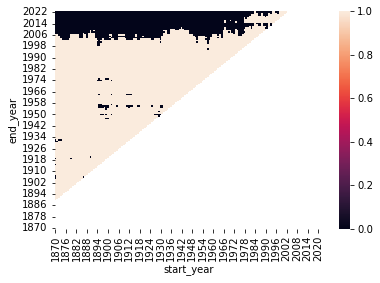

In [17]:
fig, ax = plt.subplots()
sns.heatmap(dfObsInRange, ax = ax)

In [21]:
# plotting a better overlapping map (i.e., with stippling)